In [4]:
import torch
from glob import glob
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from IPython.core.display import display, HTML
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [5]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)

plt.style.use('dark_background')

display(HTML("<style>"
    + "#notebook { padding-top:0px; } " ""
    + ".container { width:100%; } "
    + ".end_space { min-height:0px; } "
    + "</style>"))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [6]:
def get_name_exp(exp: dict):
    interesting_props = ['buffer_size']
    props = {}
    for prop in interesting_props:
        if prop in exp:
            props[prop] = exp[prop]
    if len(props) == 0: props = ''
    return f'{exp["model"]} {props}'

def print_exp_info(exp: dict):
    print(f'model: {get_name_exp(exp)}')
    print({k: exp[k] for k in exp if k not in ['latents']})

In [7]:
def calc_ADL_from_dist(dist_matrix: torch.Tensor, sigma=1.):
    # compute affinity matrix, heat_kernel
    A = torch.exp(-dist_matrix / (sigma ** 2))
    # compute degree matrix
    D = torch.diag(A.sum(1))
    # compute laplacian
    L = D - A
    return A, D, L

def calc_euclid_dist(data: torch.Tensor):
    return ((data.unsqueeze(0) - data.unsqueeze(1)) ** 2).sum(-1)

def calc_dist_weiss(nu: torch.Tensor, logvar: torch.Tensor):
    var = logvar.exp()
    edist = calc_euclid_dist(nu)
    wdiff = (var.unsqueeze(0) + var.unsqueeze(1) -2*(torch.sqrt(var.unsqueeze(0)*var.unsqueeze(1)))).sum(-1)
    return edist + wdiff

def calc_ADL_knn(distances: torch.Tensor, k: int, symmetric: bool = True):
    new_A = torch.clone(distances)
    mask = torch.eye(new_A.shape[0])
    new_A[mask==1] = +torch.inf

    final_A = torch.zeros_like(new_A)
    idxes = new_A.topk(k, largest=False)[1]
    final_A[torch.arange(len(idxes)).unsqueeze(1), idxes] = 1

    if symmetric:
        final_A = ((final_A + final_A.T) > 0).float()
        # final_A = 0.5*(final_A + final_A.T)

    # compute degree matrix
    D = torch.diag(final_A.sum(1))
    # compute laplacian
    L = D - final_A
    return final_A, D, L

def calc_ADL(data: torch.Tensor, sigma=1.):
    return calc_ADL_from_dist(calc_euclid_dist(data), sigma)

def find_eigs(laplacian: torch.Tensor, n_pairs:int=0, largest=False ):
    if n_pairs > 0:
        eigenvalues, eigenvectors = torch.lobpcg(laplacian, n_pairs, largest=largest)
    else:
        eigenvalues, eigenvectors = torch.linalg.eigh(laplacian)
        # eigenvalues = eigenvalues.to(float)
        # eigenvectors = eigenvectors.to(float)
        sorted_indices = torch.argsort(eigenvalues, descending=largest)
        eigenvalues, eigenvectors = eigenvalues[sorted_indices], eigenvectors[:,sorted_indices]

    return eigenvalues, eigenvectors

def calc_energy_from_values(values: torch.Tensor, norm=False):
    nsamples = len(values)
    max_value = nsamples - 1 if norm else nsamples * (nsamples - 1)
    dir_energy = values.sum()
    energy_p = dir_energy / max_value
    return energy_p.cpu().item()

def normalize_A(A, D):
    inv_d = D.pow(-0.5)
    inv_d[torch.isinf(inv_d)] = 0
    # return torch.sqrt(torch.linalg.inv(D)) @ A @ torch.sqrt(torch.linalg.inv(D))
    return inv_d @ A @ inv_d

def dir_energy_normal(data: torch.Tensor, sigma=1.):
    A, D, L = calc_ADL(data, sigma)
    L_norm = torch.eye(A.shape[0]).to(device) - normalize_A(A, D)
    eigenvalues, eigenvectors = find_eigs(L_norm)
    energy = calc_energy_from_values(eigenvalues, norm=True)
    return energy, eigenvalues, eigenvectors

def dir_energy(data: torch.Tensor, sigma=1):
    A, D, L = calc_ADL(data, sigma=sigma)
    eigenvalues, eigenvectors = find_eigs(L)
    energy = calc_energy_from_values(eigenvalues)
    return energy

def laplacian_analysis(data: torch.Tensor, sigma=1., knn=0, logvars: torch.Tensor=None,
                       norm_lap=False, norm_eigs=False, n_pairs=0):
    if logvars is None:
        distances = calc_euclid_dist(data)
    else:
        distances = calc_dist_weiss(data, logvars)
    if knn > 0:
        A, D, L = calc_ADL_knn(distances, knn, symmetric=True)
    else:
        A, D, L = calc_ADL_from_dist(distances, sigma)
    if norm_lap:
        L = torch.eye(A.shape[0]).to(device) - normalize_A(A, D)
    eigenvalues, eigenvectors = find_eigs(L, n_pairs=n_pairs)
    energy = calc_energy_from_values(eigenvalues, norm=norm_lap)
    if norm_eigs and not norm_lap:
        eigenvalues = eigenvalues / (len(eigenvalues))
    return energy, eigenvalues, eigenvectors, L

In [8]:
def flatten_list(l: List[List[any]]) -> List[any]:
    return [item for line in l for item in line]

def get_knowledge_list(exp: dict):
    knowledge = [k for k in exp['knowledge'].values()]
    for i in range(1, len(knowledge)):
        knowledge[i] = [k for k in knowledge[i] if k not in flatten_list(knowledge[:i])]
    return knowledge

In [9]:
logs_path = 'C:\\Users\\emace\\AImageLab\\SRV-Continual\\results\\canomaly\\logs'
logs_path = '/nas/softechict-nas-2/efrascaroli/mammoth-data/logs'
# logs_path = '/nas/softechict-nas-1/rbenaglia/canomaly-data/logs'
# logs_path = '../storage/logs'

In [10]:
exp_list = []
environments = []
for log_file in glob(logs_path + '/**/*.pyd', recursive=True):
    print(log_file)
    with open(log_file, 'r') as f:
        props_list = [prop.split('-', 1) for prop in log_file.replace(logs_path, '').split('\\')[1:-1]]
        props = {prop[0]: prop[1] for prop in props_list}
        exps = []
        for i, line in enumerate(f.readlines()):
            try:
                exps.append(literal_eval(line.replace('nan', 'None')))
            except:
                print(f'Unparsed line {i}:\n\t{exps[:-1]}\n-->\t{line}')

        environments.append({'env': props, 'exps': exps})

        exp_list.extend(exps)

/nas/softechict-nas-2/efrascaroli/mammoth-data/logs/seq-cifar10/er_con/latents.pyd
/nas/softechict-nas-2/efrascaroli/mammoth-data/logs/seq-cifar100-10x10/er_con/latents.pyd


In [11]:
print(f'Total exps: {len(exp_list)}')

Total exps: 6


model: er_con {'buffer_size': 0}
{'seed': None, 'notes': None, 'csv_log': False, 'tensorboard': False, 'validation': False, 'dataset': 'seq-cifar100-10x10', 'model': 'er_con', 'lr': 0.1, 'batch_size': 32, 'n_epochs': 50, 'buffer_size': 0, 'minibatch_size': 32, 'conf_jobnum': '9bec1f5e-fb93-40a1-94aa-d4f8e0882134', 'conf_timestamp': '2022-04-28 14:51:39.150433', 'conf_host': 'germano'}


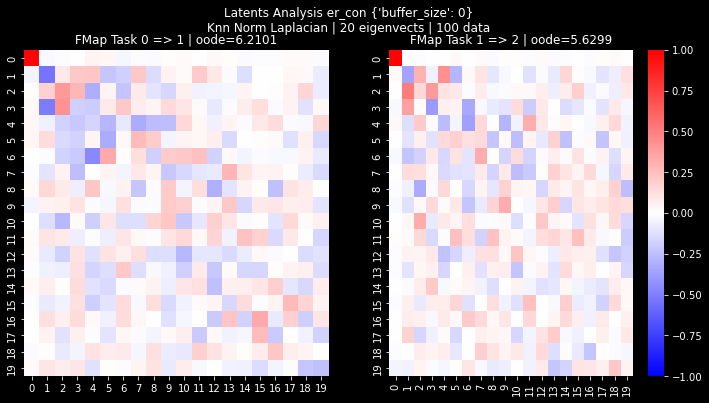

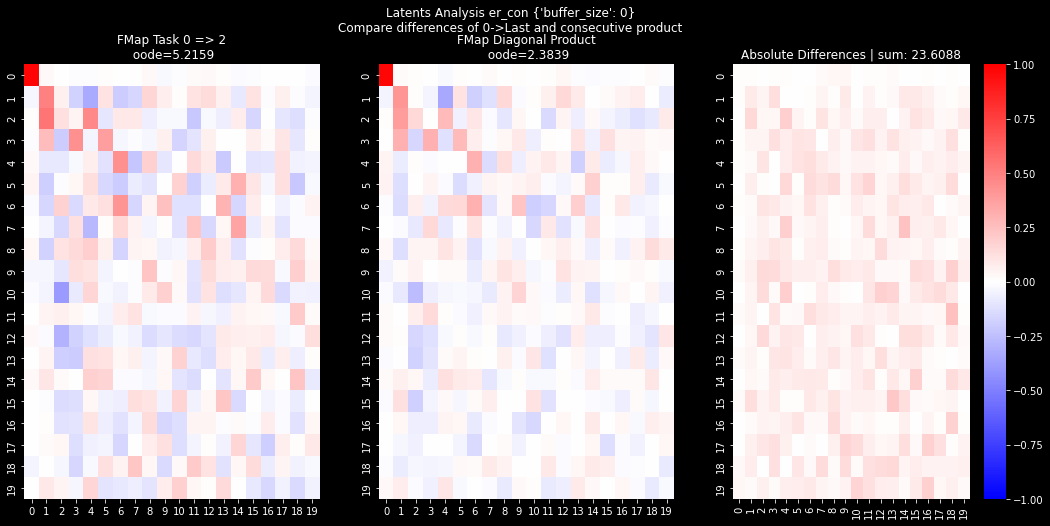

model: er_con {'buffer_size': 100}
{'seed': None, 'notes': None, 'csv_log': False, 'tensorboard': False, 'validation': False, 'dataset': 'seq-cifar100-10x10', 'model': 'er_con', 'lr': 0.1, 'batch_size': 32, 'n_epochs': 50, 'buffer_size': 100, 'minibatch_size': 32, 'conf_jobnum': '8524035c-256a-4443-a13d-4f27a0c08a13', 'conf_timestamp': '2022-04-28 15:00:20.893188', 'conf_host': 'lurcanio'}


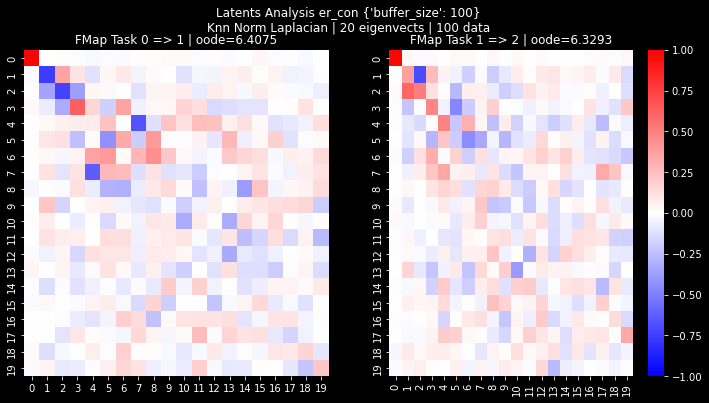

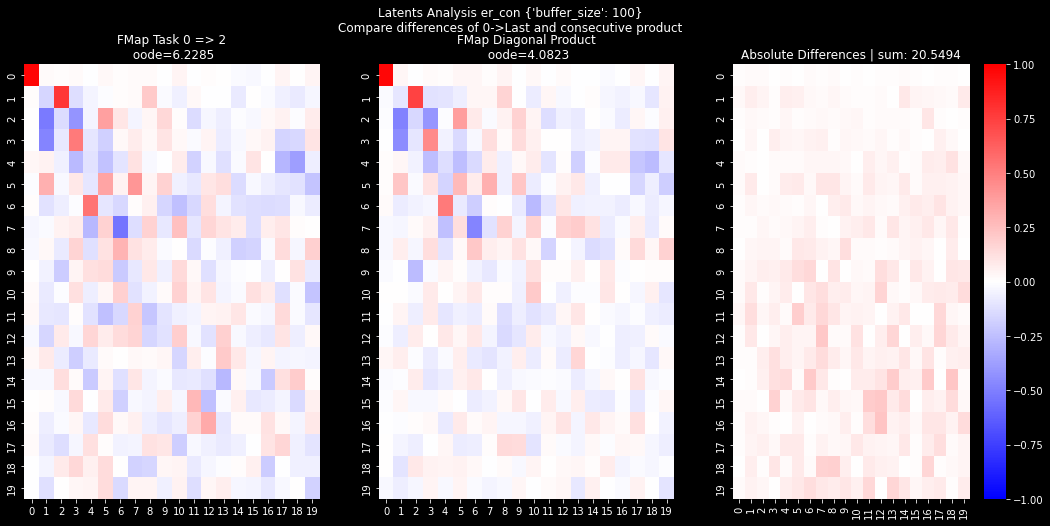

model: er_con {'buffer_size': 1000}
{'seed': None, 'notes': None, 'csv_log': False, 'tensorboard': False, 'validation': False, 'dataset': 'seq-cifar100-10x10', 'model': 'er_con', 'lr': 0.1, 'batch_size': 32, 'n_epochs': 50, 'buffer_size': 1000, 'minibatch_size': 32, 'conf_jobnum': 'dcb4a8e7-94b5-4efa-9f59-8332bcc3d7e8', 'conf_timestamp': '2022-04-28 15:02:28.398393', 'conf_host': 'nullazzo'}


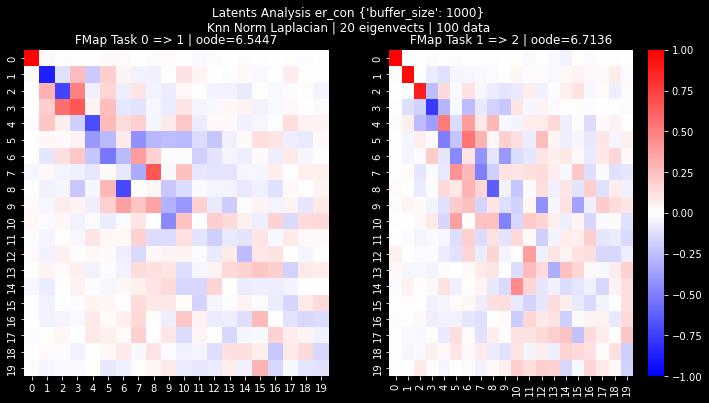

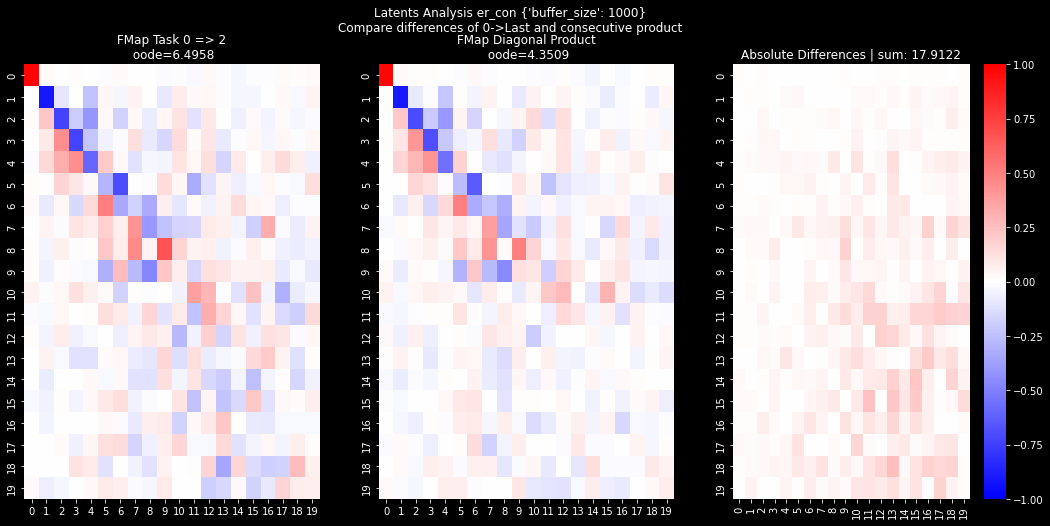

In [13]:
def fmaps_progress_cmp(exp: dict, n_vects=20, on_all=True, details=False):
    print_exp_info(exp)
    sigma = 10
    k = 10

    evects: list[torch.Tensor] = []
    for task_idx in exp['latents']:
        if task_idx > 2:
            continue
        latents = torch.tensor(exp['latents'][task_idx], device=device)

        energy, eigenvalues, eigenvectors, L = laplacian_analysis(latents, sigma=sigma,
                                                                  norm_lap=True, norm_eigs=False, knn=k)
        evects.append(eigenvectors)

    ncols = len(evects) - 1
    figsize = (6*ncols, 6)
    fig, ax = plt.subplots(1, ncols, figsize=figsize)
    plt.suptitle(f'Latents Analysis {get_name_exp(exp)}'
                     f'\nKnn Norm Laplacian | {n_vects} eigenvects | {len(evects[0])} data')
    mask = torch.eye(n_vects) == 0
    c_0_last = evects[0][:, :n_vects].T @ evects[len(evects)-1][:, :n_vects]
    c_product = torch.ones((n_vects, n_vects), device=device, dtype=torch.double)
    for i, ev in enumerate(evects[:-1]):
        c = ev[:, :n_vects].T @ evects[i+1][:, :n_vects]
        if i == 0:
            c_product = c.clone()
        else:
            c_product = c_product @ c
        oode = torch.square(c[mask]).sum().item()
        sns.heatmap(c.cpu(), cmap='bwr', vmin=-1, vmax=1, ax=ax[i], cbar=True if i+1 == ncols else False)
        ax[i].set_title(f'FMap Task {i} => {i+1} | oode={oode:.4f}')
    if details: plt.show()
    else: plt.close()

    figsize = (6*3, 8)
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    plt.suptitle(f'Latents Analysis {get_name_exp(exp)}'
                 f'\nCompare differences of 0->Last and consecutive product')

    oode = torch.square(c_0_last[mask]).sum().item()
    sns.heatmap(c_0_last.cpu(), cmap='bwr', vmin=-1, vmax=1, ax=ax[0], cbar=False)
    ax[0].set_title(f'FMap Task 0 => {len(evects)-1}\n oode={oode:.4f}')
    oode = torch.square(c_product[mask]).sum().item()
    sns.heatmap(c_product.cpu(), cmap='bwr', vmin=-1, vmax=1, ax=ax[1], cbar=False)
    ax[1].set_title(f'FMap Diagonal Product\n oode={oode:.4f}')
    diff = (c_0_last - c_product).abs()
    sns.heatmap(diff.cpu(), cmap='bwr', vmin=-1, vmax=1, ax=ax[2], cbar=True)
    ax[2].set_title(f'Absolute Differences | sum: {diff.sum().item():.4f}')
    plt.show()


n_exps = [2 ,0, 1]  # Cifar10
n_exps = [3, 4, 5]  # Cifar100
for n_exp in n_exps:
    # fmaps_progress_cmp(exp_list[n_exp], max_task=250, on_all=False, details=False)
    fmaps_progress_cmp(exp_list[n_exp], details=True)

In [ ]:
def check_exp(exp: dict):
    print_exp_info(exp)
    task0l = exp['results']['0']['latents']
    task1l = exp['results']['3']['latents']
    print((torch.tensor(task0l) == torch.tensor(task1l)).all())
    print(task0l[0])
    print(task1l[0])

# check_exp(exp_list[7])